# Race-Memory Project Analysis

This is a trimmed notebook containing only plots used in my CNS poster, using the main dataset (within-group encoding pairings, within-group AFC pairings at retrieval, slider retrieval probe, version1_gray_lm stimuli, run on Prolific).

### Load libraries and functions

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
import scipy.stats as sp
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from ast import literal_eval
from IPython.display import Markdown as md
import re, os
pd.options.mode.chained_assignment = None 
import warnings ; warnings.filterwarnings('ignore')
downloads_path = '/Users/chrisiyer/Downloads/'

In [2]:
# import custom functions
import functions as fun
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [3]:
# meta = fun.load_metadata() # load metadata just in case

### Load data

In [4]:
data_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/'
# files = [i for i in os.listdir(data_path) if i.startswith('taskdata')]
files = [
    'taskdata_chris_main_task_pilot_prolific_afc_25_04_2022.csv',
    'taskdata_chris_main_task_2_prolific_afc3_20_05_2022.csv',
    'taskdata_chris_main_task_3_sona_afc3_11_07_2022.csv',
    
    'taskdata_chris_main_task_5_prolific_afc4_14_09_2022.csv',
    'taskdata_chris_main_task_5_prolific_afc5_12_09_2022.csv',
    # 'taskdata_chris_main_task_5_prolific_afc6_26_09_2022.csv'
        # this one had only 20 trials, better to exclude
]
df_list = []
for f in files:
    df_list.append(pd.read_csv(data_path + f))
df = pd.concat(df_list)

In [5]:
# fill in tilt_difference and tilt_change
for i in range(len(df)):
    if 'retrieval' in df.trial_type.iloc[i]:
        if pd.isna(df.tilt_difference.iloc[i]) and not pd.isna(df.old_tiltLR.iloc[i]) and not pd.isna(df.old_original_tiltLR.iloc[i]):
            tilt = fun.get_tilt_change(df.old_original_tiltLR.iloc[i], df.old_tiltLR.iloc[i])
            df['tilt_difference'].iloc[i] = tilt['difference']
            df['tilt_change'].iloc[i] = tilt['change'] 
if df[df.trial_type == 'retrieval'].tilt_difference.isna().sum() != 0:
    print('tilt difference incomplete')
else: print('all good!')
if df[df.trial_type == 'retrieval'].tilt_change.isna().sum() != 0:
    print('tilt change incomplete')
else: print('all good!')

all good!
all good!


In [6]:
# add 'tilted' boolean column
df['tilted'] = (df['tilt_difference'] != 0) & ( (df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice') )  
df.loc[(df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice'), 
       'response'] = pd.to_numeric(df.loc[(df['trial_type'] == 'retrieval') | 
                                          (df['trial_type'] == 'retrieval_practice'), 
                                          'response'])

In [7]:
df['iteration'] = df['iteration'].replace(['sona_af3'],'sona_afc3') # typo in one iteration

In [8]:
df_noexcludes = df.copy()

### Subject Exclusions

In [9]:
# 1. PROLIFIC GLITCH (subjects who confirmed glitch) from 'prolific_afc_50_subjects'
# one of these participants got like 70% on the retrieval trials they did. So maybe scrap the whole iteration?
prolific_glitch = [
    '5e68682ce3b2f71041fa03d2', 
    '610d170f7bb4e720cb85b6b2',
    '580bea98827ca10001db514e',
    '60ba71aa8f2ae12d3a595982'
]
prolific_glitch = [i for i in prolific_glitch if i in df.subject_id.unique()]
df = df[~df.subject_id.isin(prolific_glitch)]
print(str(len(prolific_glitch)) + ' PROLIFIC IDS EXCLUDED:', '\n', prolific_glitch)

0 PROLIFIC IDS EXCLUDED: 
 []


In [10]:
# 2. UNFINISHED EXPERIMENT (there are many b/c df contains data from a glitchy run)
# This includes 9 subjects from a glitchy run in pilot_prolific_afc2, 11+ others from elsewhere
# This is computed based on if there is a 'summary' trial or not
df = fun.exclude_nofinish(df) 

11 EXPERIMENT IDS EXCLUDED:
 [nan, 'j0affkyqlvgwemu5u65w', 'xfroyonoy8tdyx7d2kp3', 'gm81dh3qu7hzeqyzo4xj', 'dx8hqjksd220019ephgq', 'xmp6jckkm584jjylvt45', 'ho9k3gph9md1o86b0k94', 'tdtkqf4ghc1t8vymsrrq', 'vqjz5est7o1le59moot8', 'ahj8ax69zza7m7ly0qhc', 'ssovnp524s3w7qtwz87d']
[0, 20, 77, 47, 7, 9, 5, 3, 3, 3, 71]


In [11]:
# 4. SKIPPED - REPEATED INCORRECT PRACTICE TRIALS
# if they got max_wrong = 5 practice trials wrong in a row, excluded
# df = fun.exclude_practice(df, max_wrong = 5)

In [12]:
# 5. TIMEOUTS - subs who timed out on everything
df = fun.exclude_timeout(df)

0 EXPERIMENT IDS EXCLUDED:
 []


In [13]:
# 6. EXCLUDE SUBJECTS BY RETRIEVAL PERFORMANCE above chance? or what
df_raw = df.copy()
df = fun.exclude_simulated_chance_retrieval(df, p=0.05, n_iter =10000)

117 EXPERIMENT IDS EXCLUDED:
 ['6edmwrn8v00wf2oo2ojd', '9xtm8uz644sfw0vkoelm', 'x0q756azb8efv63xjgne', '5qcex59gryc52xh36b3v', 'qvfp5f8n8rt7ejbhlj0d', '2q4825m0ncrz5t366ens', 'zvm9oojxeu5hbcugtn84', 'm92k0q7csk9pada5fk4l', 'tputrz94ugbl5sv9bgcw', 'c6yvsu553qlwa0wtk977', 'yoshyhorga78vn9xqdd6', '2hxnye1m2ju781asz3b7', '0x60ekhm3ve3ot9yspju', 'azrtj9p25kob54a6f0fm', 'vgpu6lk6pjmmay6jt7tl', '0sye4efv1t9stj5b6lau', 'y57ddbyw4v0jpg3tmert', 'kmk9mhv84w29tr005aan', '34u200a7eyfwnck57urr', 'as2pyeoy9jc2lf00v2w6', 'clojq8kone3y5j4gkrbg', '7h7a3k7923pj27vsa9h9', '1rk8n1qfjzk3z947wo5z', 'ran67u86fmqocnex39nl', '8nf0mxy2s13v0h1d2g0q', '94p80499azpopbew2pps', '4mdrmlmmovg12kol3mnk', '0x41xoc9y1pw5z6u0az8', 'gb2p5s4n28w6n0hbu9uv', '7fztb30q3vhdl3owaq7o', '9167r7q1sxxcq72frkal', 'oduy6mmatfy9uuxp8wk5', '7mqlc182s6s670spnmh0', 'pkwvpf1k9ceda8717wot', '6d0gkkrvqa5tgokfn17o', 'w4e5tmjahaj6utu48jxb', '17ej9gprt0mpje4bhq78', '7eepe1jpgo05z31fas52', '1eqlvn9969ar3o021n3c', 'fdxg256oxxutduwp1sm4', 'v0kzqobm

In [14]:
# 7. CHECK ITERATIONS
# 'pilot_prolific_afc', 'prolific_afc3', 'sona_afc3': these are the within-race AFC pairing iterations
iterations = ['pilot_prolific_afc', 'prolific_afc3', 'sona_afc3',
             'prolific_afc4', 'prolific_afc5']
df = df[df.iteration.isin(iterations)]

### Remaining subject demographics

In [15]:
print('# of participants remaining:')
print(len(df.experiment_id.unique()))

print('Original number of subjects: ', len(df_noexcludes.experiment_id.unique()))

# of participants remaining:
61
Original number of subjects:  189


In [16]:
# 6. SEPARATE DF with just white-identifying subjects
df_white = df[df.experiment_id.isin(
    df[df.race == "['White']"].experiment_id.unique()
)]

print(len(df.experiment_id.unique()))
print(len(df_white.experiment_id.unique()))

61
35


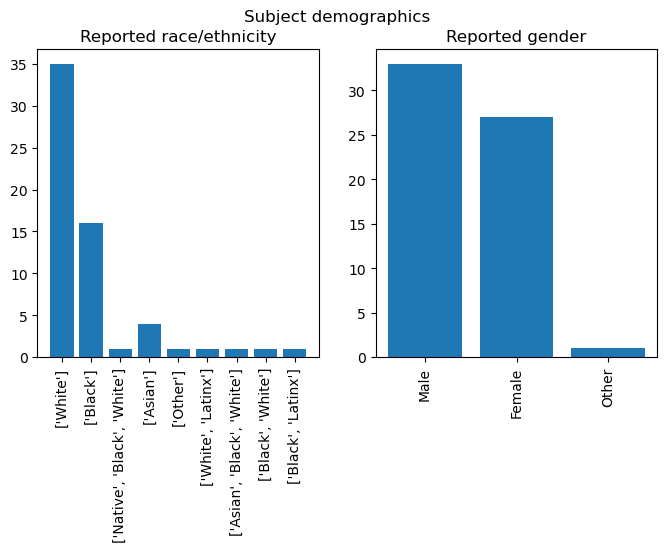

["['White']" "['Black']" "['Native', 'Black', 'White']" "['Asian']"
 "['Other']" "['White', 'Latinx']" "['Asian', 'Black', 'White']"
 "['Black', 'White']" "['Black', 'Latinx']"]
[35, 16, 1, 4, 1, 1, 1, 1, 1]
33 women, 27 men


In [17]:
fun.demographics_plot(df)

In [18]:
print('Age range: ' + str(df.age.min()) + " - " + str(df.age.max()))
print('Median age: ' + str(df.age.median()))

Age range: 18.0 - 67.0
Median age: 31.0


## Poster Plots

In [619]:
save = True

### Get stats
Stats, stats_wb, stats_byface, stats_enc_split

In [19]:
stats = fun.get_stats(df, only_correct_encoding = True, only_high_confidence = False)
stats_orig = stats.copy()

In [20]:
# stats_raw = fun.get_stats(df_raw, only_correct_encoding = True, only_high_confidence = False)
stats_wb = {'white': stats[stats.race.str.contains('White')],
          'black': stats[stats.race.str.contains('Black')]}

In [21]:
stats_byface = fun.get_stats_byface(df, only_correct_encoding=True, only_high_confidence = False)

In [22]:
stats_enc_split = fun.get_encoding_split_stats(df, only_correct_encoding = True, only_high_confidence = False)

### Figure 1
Encoding RT & accuracy by race (subject-level)

In [29]:
plt.rcParams['font.family'] = 'serif'

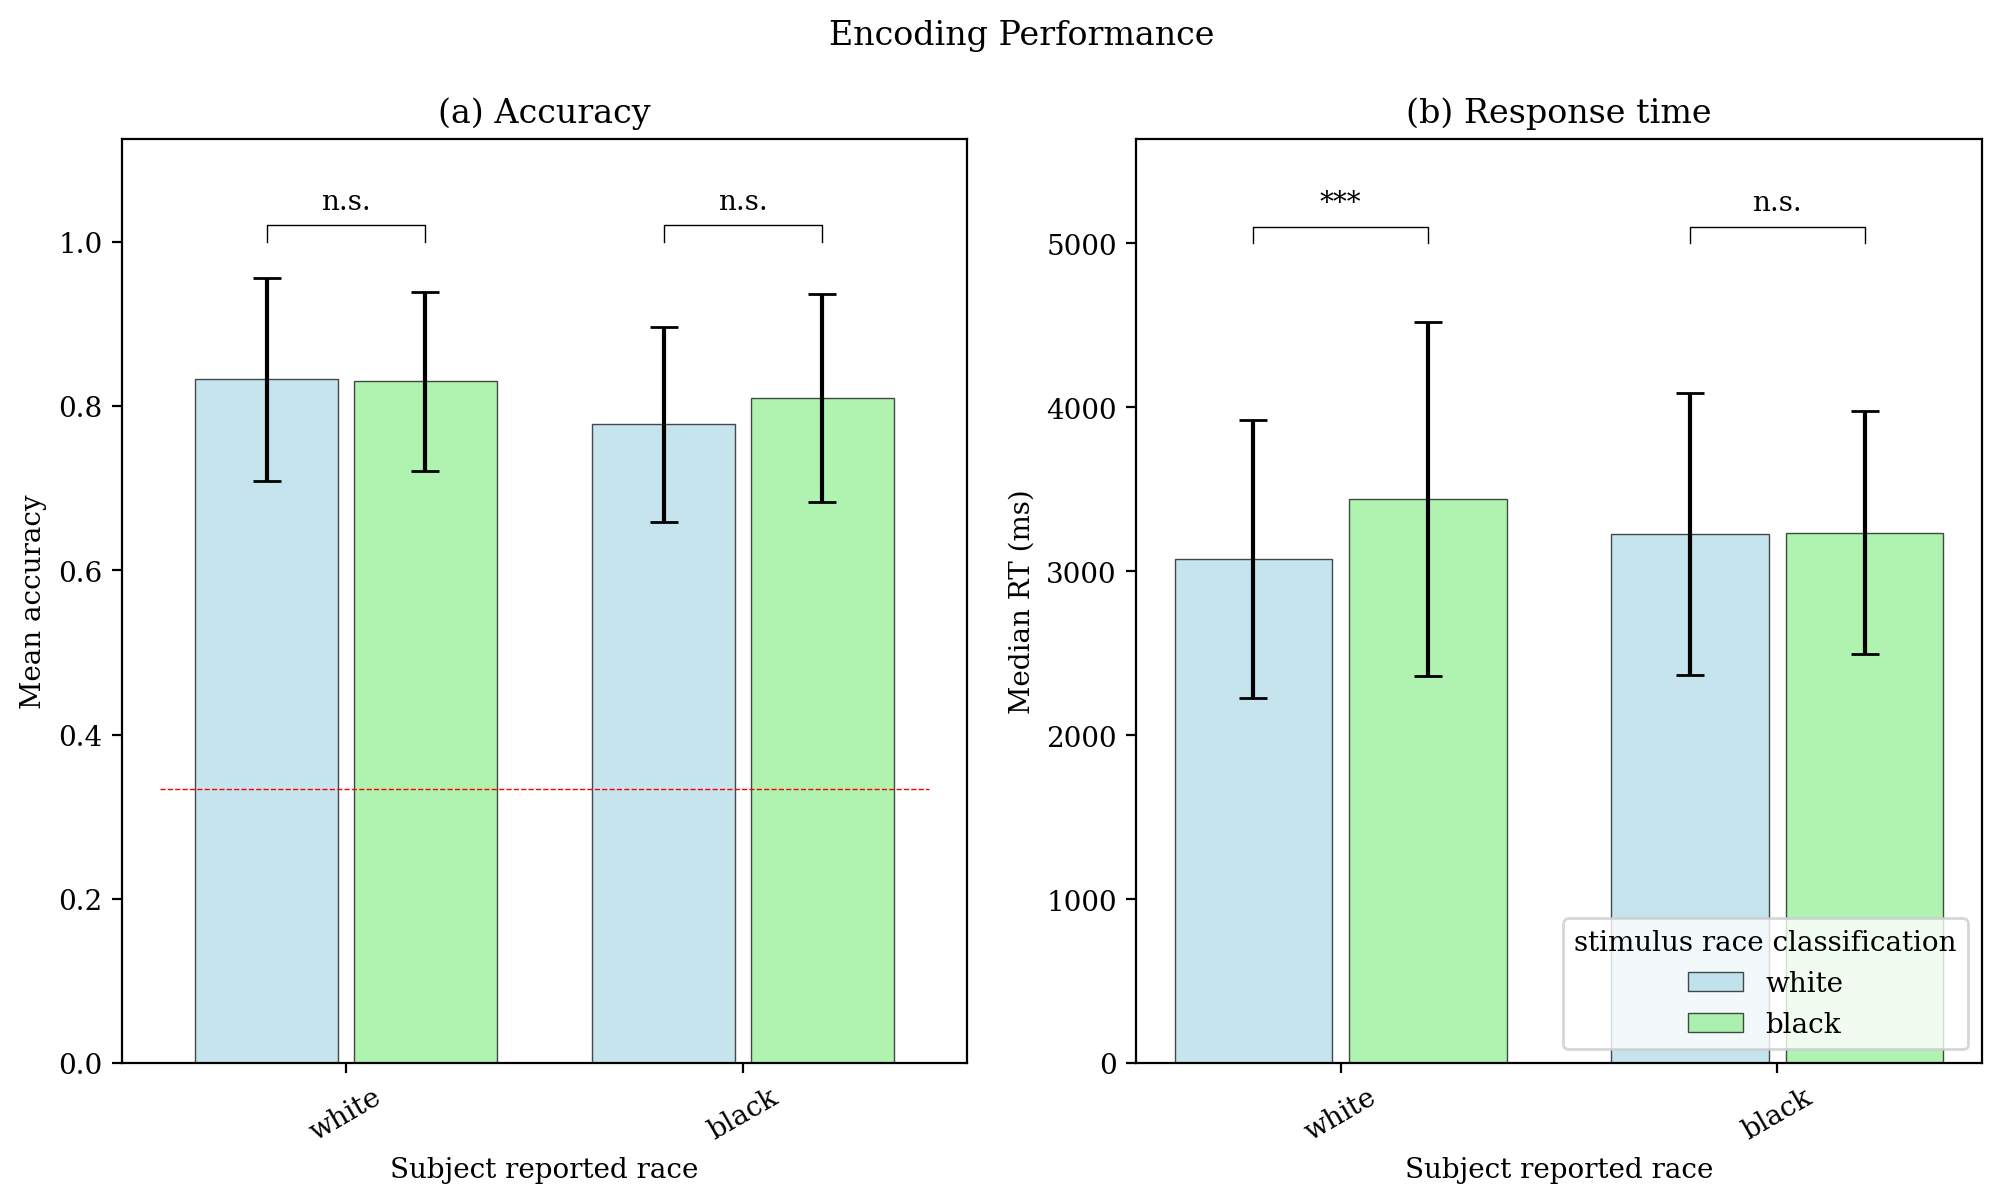

In [620]:
color = [[.68,.85,.90], [.56,.93,.56], ] # lightblue, lightgreen

intervals = [0.25,0.5]
buffer = 0.05
al = 0.7
al2 = 0.7 # edge
lw= 0.5
    
fig, ax = plt.subplots(1,2, figsize = (12,6), dpi=200)
fig.suptitle('Encoding Performance')
ax[0].set_title('(a) Accuracy')
ax[0].set_ylabel('Mean accuracy')
ax[0].set_xlabel('Subject reported race')
ax[0].set_ylim([0,1.125])
ax[0].set_yticks(np.linspace(0,1,6))
ax[0].set_xticklabels([*stats_wb], rotation=30)
ax[0].set_xticks(intervals)

ax[0].bar(
    [intervals[0]-buffer, intervals[1]-buffer],
    [stats_wb['white']['enc_acc_w'].mean(), stats_wb['black']['enc_acc_w'].mean()],
    yerr = [stats_wb['white']['enc_acc_w'].std(), stats_wb['black']['enc_acc_w'].std()], 
    alpha = al2, facecolor = color[0]+[al], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'white'
)
ax[0].bar(
    [intervals[0]+buffer, intervals[1]+buffer],
    [stats_wb['white']['enc_acc_b'].mean(), stats_wb['black']['enc_acc_b'].mean()],
    yerr = [stats_wb['white']['enc_acc_b'].std(), stats_wb['black']['enc_acc_b'].std()], 
    alpha = al2, facecolor = color[1]+[al], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'black'
)

for i in range(len(intervals)):
    x1, x2 = (intervals[i]-buffer, intervals[i]+buffer)
    h = 0.02
    y = 1.0
    ax[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, color = 'black')
    sig = fun.get_sig(sp.wilcoxon(stats_wb[[*stats_wb][i]].enc_acc_delta).pvalue)
    ax[0].text(intervals[i],y+h*2, sig, ha ='center', fontsize=10)
ax[0].plot([ax[0].get_xlim()[0],ax[0].get_xlim()[1]],[1/3,1/3], color = 'red', ls = '--', linewidth=lw)

ax[1].set_title('(b) Response time')
ax[1].set_ylabel('Median RT (ms)')
ax[1].set_xlabel('Subject reported race')
ax[1].set_ylim([0,max(stats.enc_rt) + 300])
ax[1].set_xticklabels([*stats_wb], rotation=30)
ax[1].set_xticks(intervals)

ax[1].bar(
    [intervals[0]-buffer, intervals[1]-buffer],
    [stats_wb['white']['enc_rt_w'].mean(), stats_wb['black']['enc_rt_w'].mean()],
    yerr = [stats_wb['white']['enc_rt_w'].std(), stats_wb['black']['enc_rt_w'].std()], 
    alpha = al2, facecolor = color[0]+[al], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'white'
)
ax[1].bar(
    [intervals[0]+buffer, intervals[1]+buffer],
    [stats_wb['white']['enc_rt_b'].mean(), stats_wb['black']['enc_rt_b'].mean()],
    yerr = [stats_wb['white']['enc_rt_b'].std(), stats_wb['black']['enc_rt_b'].std()], 
    alpha = al2, facecolor = color[1]+[al], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'black'
)

for i in range(len(intervals)):
    x1, x2 = (intervals[i]-buffer, intervals[i]+buffer)
    h = 100
    y = 5000
    ax[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, color = 'black')
    sig = fun.get_sig(sp.ttest_1samp(stats_wb[[*stats_wb][i]].enc_rt_delta, 0).pvalue)
    ax[1].text(intervals[i],y+h*2, sig, ha ='center', fontsize=10)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), ['white','black'], loc='lower right', title='stimulus race classification')
if save: plt.savefig('/Users/chrisiyer/Downloads/fig1_encoding.png', dpi=200)
plt.show()

### Figure 2
Retrieval accuracy by tilt, race, and tilt x race

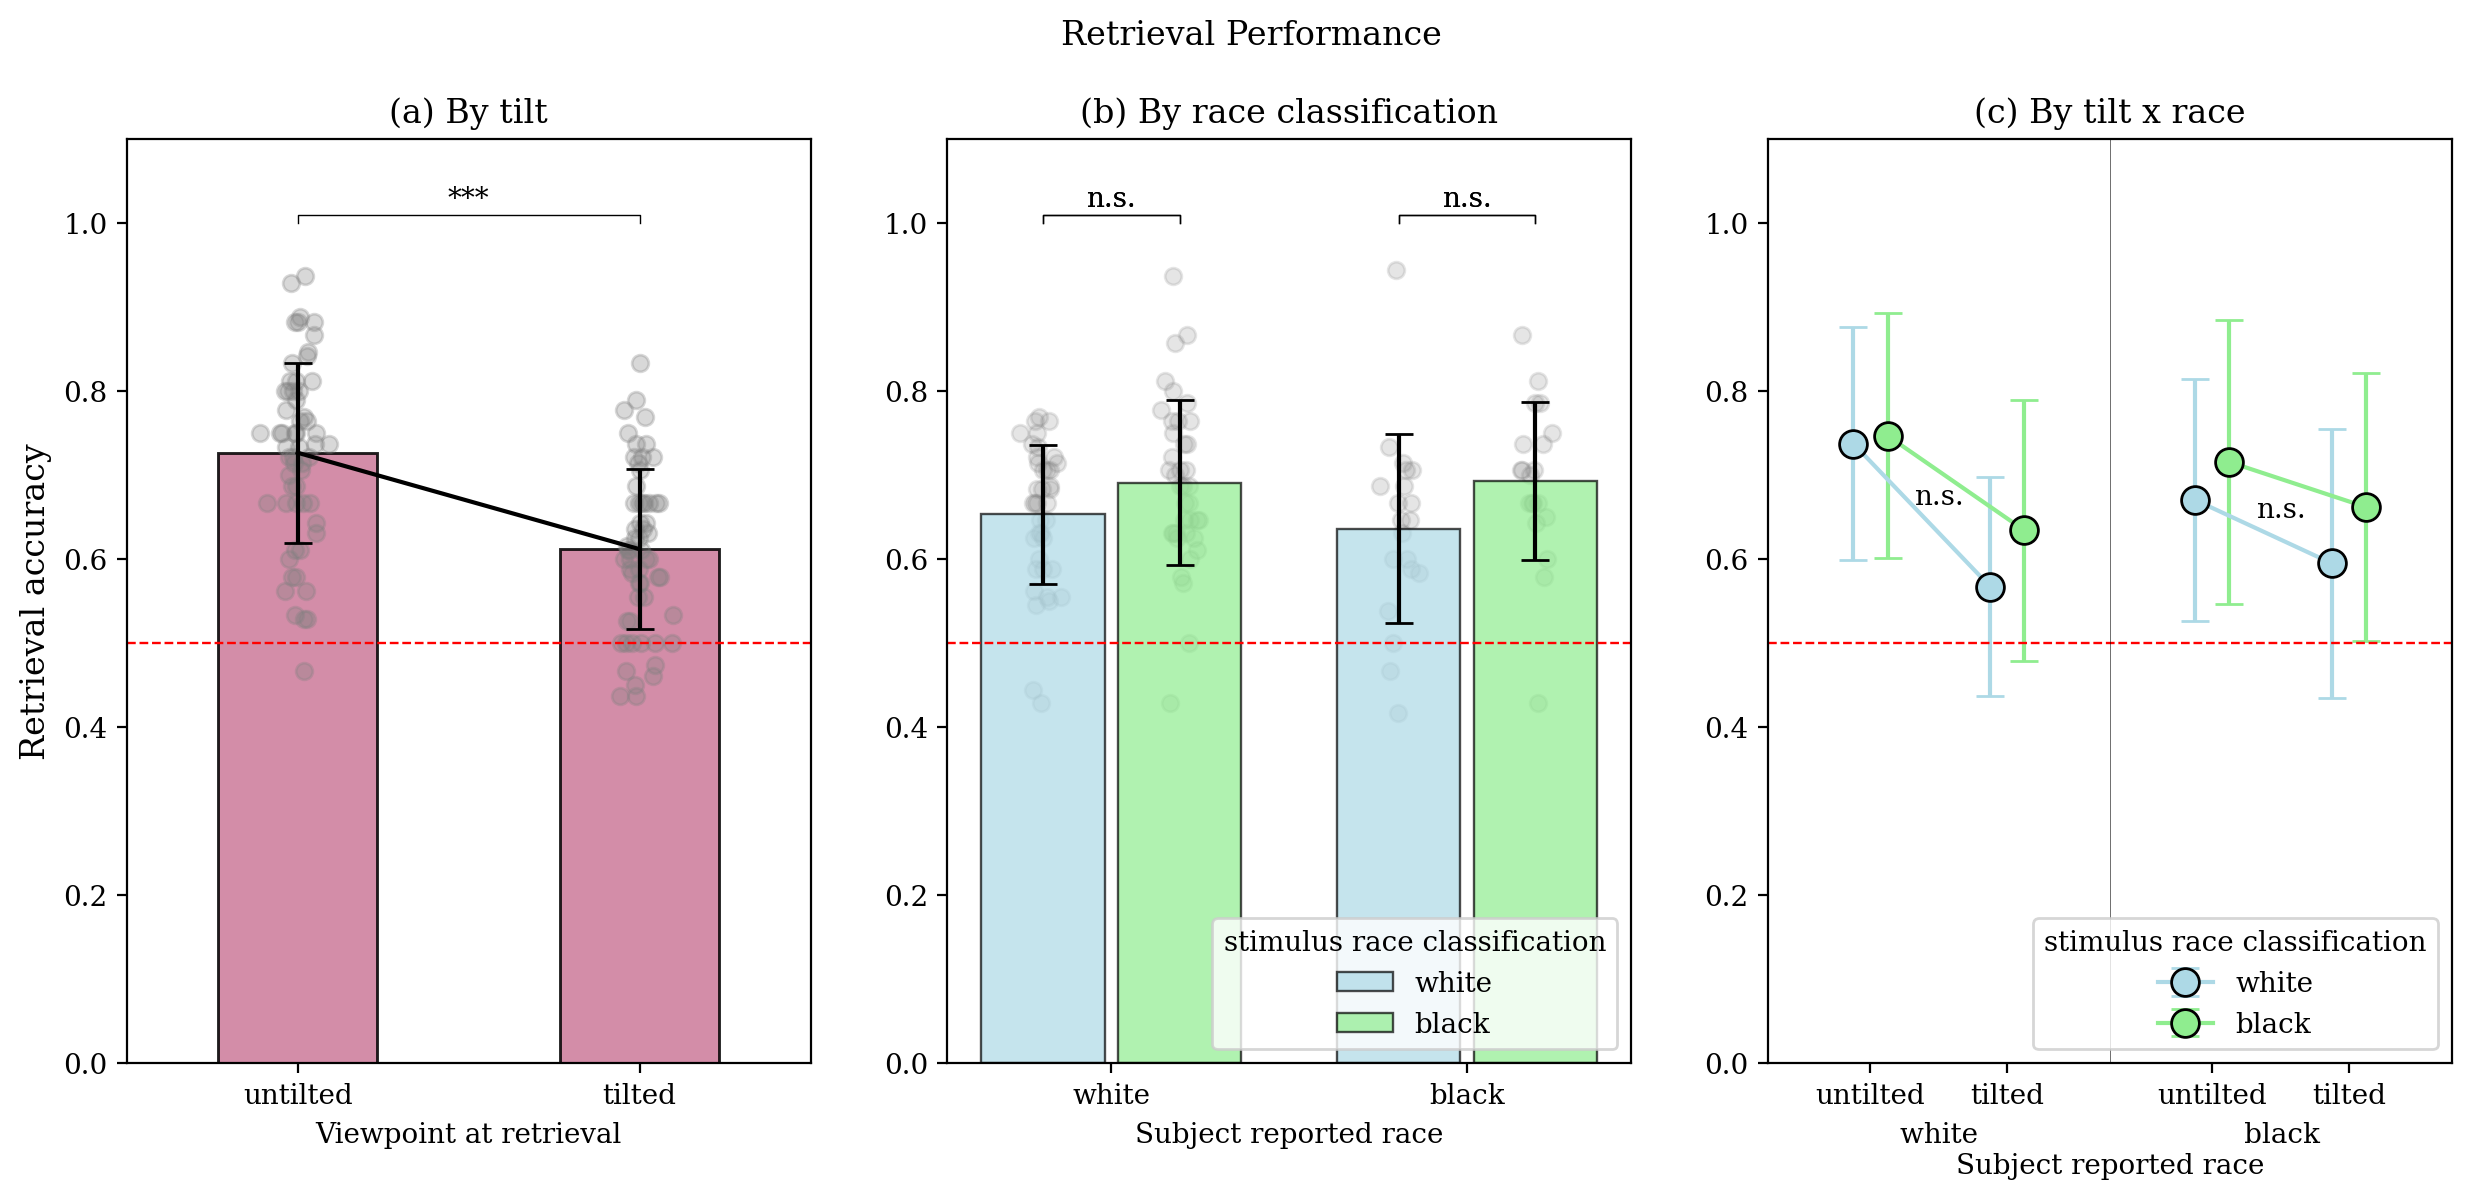

In [621]:
lw=0.85
color = [[.68,.85,.90], [.56,.93,.56], [.69,.19,.38]] # lightblue, lightgreen, maroon
al2 = 0.7 # edges

slider=False

fig, ax = plt.subplots(1,3, figsize = (15,6), dpi=200)
fig.suptitle('Retrieval Performance')

data = pd.concat(stats_wb.values())

if slider: 
    measure = 'ret_dist'
    ylab = 'Retrieval slider error'
    plt.setp(ax, ylim = [0,110])
else: 
    measure = 'ret_acc'
    ylab = 'Retrieval accuracy'
    plt.setp(ax, ylim = [0,1.1])
title = ylab

intervals = [0.075,0.225]
buffer = 0.05
jit = 0.005
al = 0.2 #alpha

ax[0].set_xlim([0,0.3])
ax[0].set_xticks(intervals)
ax[0].set_xticklabels(['untilted', 'tilted'])
ax[0].set_xlabel('Viewpoint at retrieval')
ax[0].set_ylabel(ylab, size ='large')
ax[0].set_title('(a) By tilt')
ax[0].errorbar(x= intervals, 
                y = data[[measure+'_0', measure+'_50']].mean(), 
                yerr = data[[measure+'_0', measure+'_50']].std(),
                capsize =5, marker = 'o', mfc = 'maroon', mec='maroon', ms =0,ecolor='black',color='black')
ax[0].bar(intervals, data[[measure+'_0', measure+'_50']].mean(), 
                #yerr = data[[measure+'_0', measure+'_50']].std(),
                capsize =5, edgecolor='black', facecolor=color[2],  linewidth = 1, width=0.07, alpha=0.55)
ax[0].bar(intervals, data[[measure+'_0', measure+'_50']].mean(), edgecolor='black', facecolor='None',  linewidth = 1, width=0.07, alpha=al2) #ugh
ax[0].scatter(x = np.array([fun.rand_jitter(np.repeat(intervals[0], len(data)), jit), 
                            fun.rand_jitter(np.repeat(intervals[1], len(data)), jit)]).flatten(),
                y = np.array([data[measure+'_0'].to_numpy(), data[measure+'_50'].to_numpy()]).flatten(),
                                color='gray',alpha=0.3)
ax[0].plot([ax[0].get_xlim()[0],ax[0].get_xlim()[1]],[0.5,0.5], color = 'red', ls = '--', linewidth=lw)

h = 0.01
y = 1
ax[0].plot([intervals[0], intervals[0], intervals[1], intervals[1]], [y, y+h, y+h, y], lw=.5, color = 'black')
sig = fun.get_sig(sp.wilcoxon(data.ret_acc_0, data.ret_acc_50).pvalue)
ax[0].text(np.mean(intervals),y+h*2, sig, ha ='center', fontsize=10)


intervals=[0.12,0.38]
buffer = 0.05
jit = 0.007
al = 0.2 #alpha

ax[1].set_xlim(0,0.5)
ax[1].set_title('(b) By race classification')
ax[1].set_xlabel('Subject reported race')
ax[1].set_xticklabels([*stats_wb])
ax[1].set_xticks(intervals)

for i in range(len(intervals)):
    data = stats_wb[[*stats_wb][i]]
    x1,x2 = (intervals[i]-buffer, intervals[i]+buffer)
    # ax[1].errorbar(x= [x1,x2], y = data[[measure + '_w', measure + '_b']].mean(), 
    #             yerr = data[[measure + '_w', measure + '_b']].std(),
    #             capsize =5, marker = 'o', mfc = 'black', mec='black', ms =0, ecolor='black', color='black')
    ax[1].scatter(x = fun.rand_jitter(np.repeat(x1, len(data)), jit), 
                y =data[measure+'_w'], color='gray', alpha=al)
    ax[1].scatter(x = fun.rand_jitter(np.repeat(x2, len(data)), jit), 
                y = data[measure+'_b'], color='gray', alpha=al)
    
    h = 0.01
    y = 1
    ax[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, color = 'black')
    sig = fun.get_sig(sp.wilcoxon(data.ret_acc_w, data.ret_acc_b).pvalue)
    ax[1].text(intervals[i],y+h*2, sig, ha ='center', fontsize=10)

ax[1].bar(
    [intervals[0]-buffer, intervals[1]-buffer],
    [stats_wb['white'][measure + '_w'].mean(), stats_wb['black'][measure + '_w'].mean()],
    yerr = [stats_wb['white'][measure + '_w'].std(), stats_wb['black'][measure + '_w'].std()], 
    alpha=al2, facecolor = color[0]+[0.6], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'white')
ax[1].bar(
    [intervals[0]+buffer, intervals[1]+buffer],
    [stats_wb['white'][measure + '_b'].mean(), stats_wb['black'][measure + '_b'].mean()],
    yerr = [stats_wb['white'][measure + '_b'].std(), stats_wb['black'][measure + '_b'].std()], 
    alpha=al2, facecolor = color[1]+[0.6], edgecolor = 'black', linewidth = lw, width = 0.09, capsize =5, label = 'black')

for i in range(len(intervals)):
    x1, x2 = (intervals[i]-buffer, intervals[i]+buffer)
    h = 0.01
    y = 1
    ax[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=.5, color = 'black')
    sig = fun.get_sig(sp.ttest_rel(stats_wb[[*stats_wb][i]]['ret_acc_w'], stats_wb[[*stats_wb][i]]['ret_acc_b']).pvalue)
    ax[1].text(intervals[i],y+h*2, sig, ha ='center', fontsize=10)

ax[1].plot([ax[1].get_xlim()[0],ax[1].get_xlim()[1]],[0.5,0.5], color = 'red', ls = '--', linewidth=lw)


intervals=[1,2]
buffer = 0.05
buffer2 = 0.2
jit = 0.01
al = 0.1 #alpha

ax[2].set_title('(c) By tilt x race')
ax[2].set_xticklabels(['untilted', 'tilted', 'untilted', 'tilted'])
ax[2].set_xlabel('white                              black\nSubject reported race')
ax[2].set_xticks([intervals[0]-buffer2, intervals[0]+buffer2, intervals[1]-buffer2, intervals[1]+buffer2])
ax[2].set_xlim([0.5,2.5])

for i in range(len(intervals)):
    data = stats_wb[[*stats_wb][i]]
    x1,x2 = (intervals[i]-buffer2, intervals[i]+buffer2)
    
    if i == 0:
        labels = ['white', 'black']
    else:
        labels = ['','']
        
    ax[2].errorbar(x = np.array([x1, x2])-buffer, 
                    y = data[[measure + '_w_0', measure + '_w_50']].mean(),
                    yerr = data[[measure + '_w_0', measure + '_w_50']].std(), 
                    capsize =5, marker = 'o', mfc = color[0], mec='black', ms =10,
                    color=color[0],ecolor=color[0], label=labels[0])
    
    ax[2].errorbar(x = np.array([x1, x2])+buffer, 
                    y = data[[measure + '_b_0', measure + '_b_50']].mean(),
                    yerr = data[[measure + '_b_0', measure + '_b_50']].std(),
                    capsize =5, marker = 'o', mfc = color[1], mec='black', ms =10,
                    color=color[1],ecolor=color[1], label=labels[1])

    # ax[2].scatter(x = [fun.rand_jitter(np.repeat(x1-buffer, len(data)), jit), fun.rand_jitter(np.repeat(x1+buffer, len(data)), jit)],
    #                y= data[[measure + '_w_0', measure + '_w_50']], alpha = al, color='gray')
    # ax[2].scatter(x = [fun.rand_jitter(np.repeat(x2-buffer, len(data)), jit), fun.rand_jitter(np.repeat(x2+buffer, len(data)), jit)],
    #                y= data[[measure + '_b_0', measure + '_b_50']], alpha = al, color='gray')
    
    sig = fun.get_sig(
        smf.ols("accuracy ~ tilt * race", data = {
        'accuracy': np.concatenate([data.ret_acc_w_0, data.ret_acc_b_0, 
                                    data.ret_acc_w_50, data.ret_acc_b_50]), 
        'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
        'race': np.concatenate([np.repeat(1, len(data)), np.repeat(0, len(data)), 
                                np.repeat(1, len(data)), np.repeat(0, len(data))])
        }).fit().pvalues[-1])
    ypos = {0: 0.665, 1:0.65}
    ax[2].text(intervals[i],ypos[i], sig, ha ='center', fontsize=10)

ax[2].plot([ax[2].get_xlim()[0],ax[2].get_xlim()[1]],[0.5,0.5], color = 'red', ls = '--', linewidth=lw)
ax[2].plot([np.mean(intervals),np.mean(intervals)],[0,1.1], color = 'black', ls = 'solid', linewidth=0.2)

ax[1].legend(loc='lower right', title='stimulus race classification')
ax[2].legend(loc='lower right', title='stimulus race classification')
if save: plt.savefig('/Users/chrisiyer/Downloads/fig2_retrieval.png', dpi=200)
plt.show()


### Figure 3
Explain retrieval accuracy with encoding RT: subject or item level?

In [233]:
# do trials with a longer vs shorter encoding RT have a higher chance of being retrieved?
# for each trial: - encoding RT, - encoding correct (filter), - retrieval response, - retrieval correct, tilt, subj race, stim race
data = df[df.trial_type.isin(['encoding', 'retrieval_practice', 'retrieval', 'demographics'])]

In [346]:
trialdata = pd.DataFrame(columns = ['enc_rt', 'enc_correct', 'ret_response', 'ret_correct', 
                                    'tilt_difference', 'subj_race', 'stim_race'])

ids = data.experiment_id.unique() 
for subj in ids[~pd.isna(ids)]:
    curr = data[data.experiment_id == subj]
    for stim in curr.old_identity.unique():
        enc_trial = curr[curr.oddity_identity == stim]
        ret_trial = curr[curr.old_identity == stim]
        dem_trial = curr[curr.trial_type == 'demographics']
        if (len(dem_trial) > 0):
            race = dem_trial.race.iloc[0]
        else:
            race = ''
        if (len(enc_trial) > 0) & (len(ret_trial) > 0):
            trialdata.loc[len(trialdata),] = [enc_trial['rt'].iloc[0], enc_trial['correct'].iloc[0], 
                                          ret_trial['response'].iloc[0], ret_trial['correct'].iloc[0],
                                          ret_trial['tilt_difference'].iloc[0], ret_trial['old_race'].iloc[0],
                                          race]

    

In [643]:
bins = np.linspace(0,10000, 11)
bindata = {'acc': [], 'std': [], 'n': []}
for i in range(len(bins)-1):
    a = trialdata[(trialdata.enc_correct == 1.0) & (trialdata.enc_rt > bins[i]) & (trialdata.enc_rt < bins[i+1])]
    bindata['acc'].append(a.ret_correct.mean())
    bindata['std'].append(a.ret_correct.std())
    bindata['n'].append(len(a))



In [646]:
bindata['n']

[6, 329, 658, 466, 235, 146, 64, 37, 26, 16]

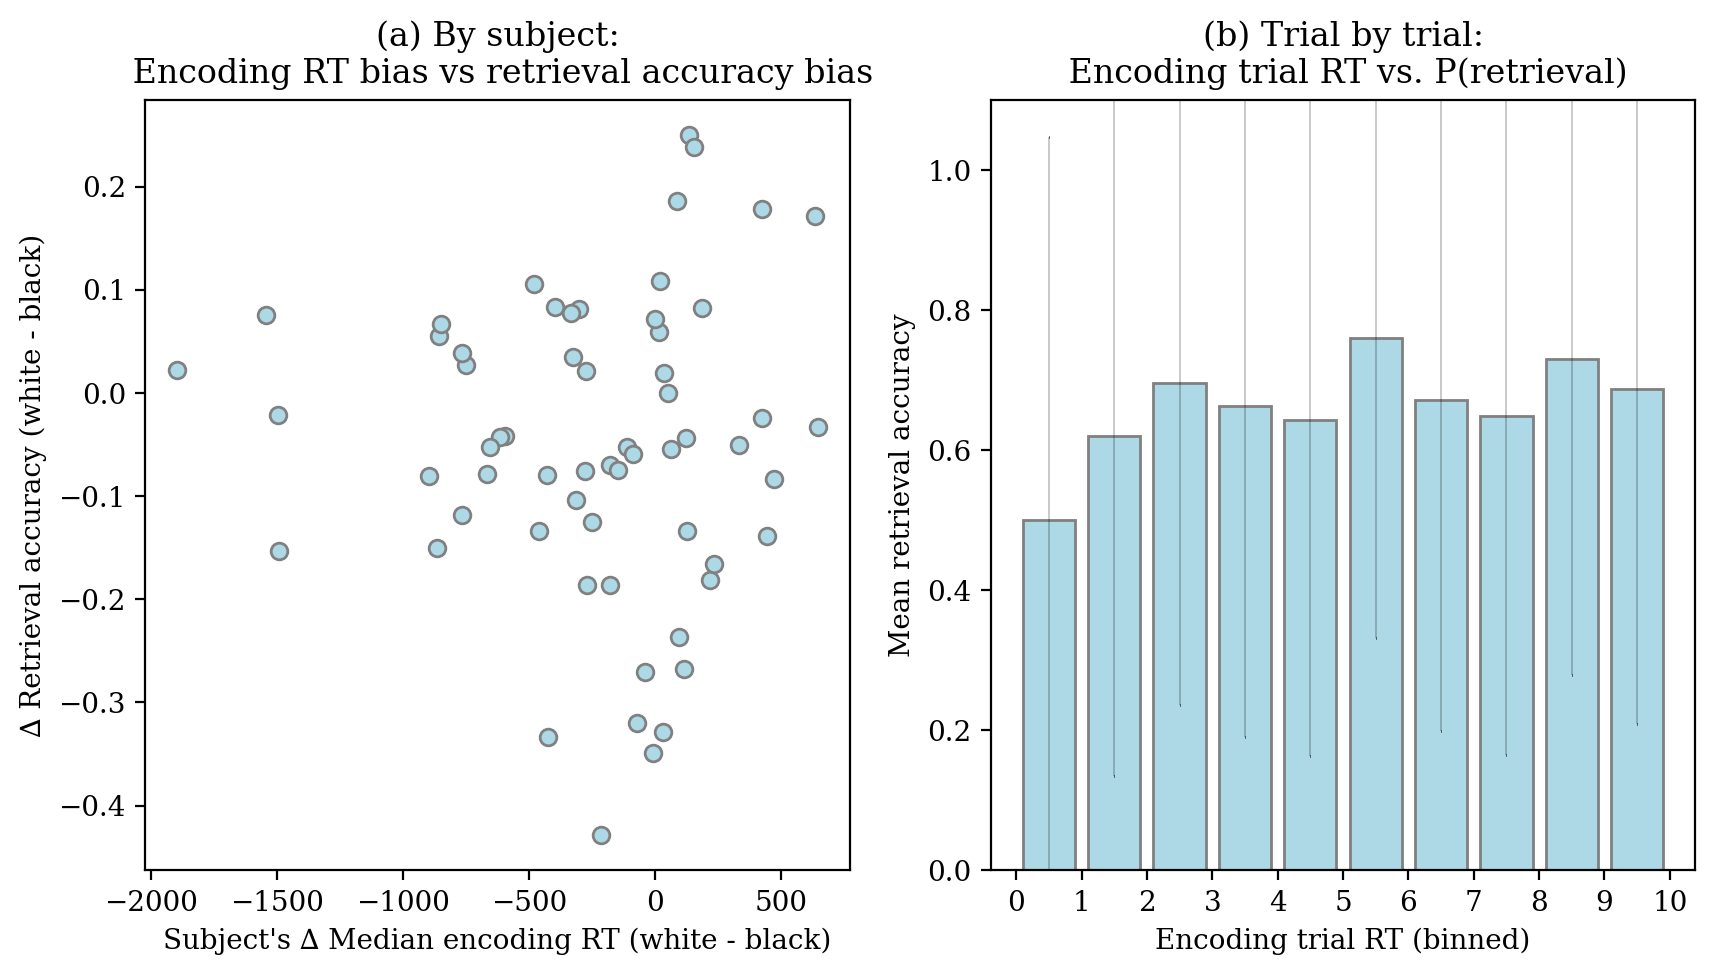

In [655]:
# by subject
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=200)
# fig.suptitle('Does encoding bias predict retrieval bias?')

if slider:
    measure = 'ret_dist_delta'
    ylab = '∆ Retrieval slider error (white - black)'
else: 
    measure = 'ret_acc_delta'
    ylab = '∆ Retrieval accuracy (white - black)'

ax[0].set_title('(a) By subject:\n Encoding RT bias vs retrieval accuracy bias')
ax[0].set_xlabel('Subject\'s ∆ Median encoding RT (white - black)')
ax[0].set_ylabel(ylab)
ax[0].scatter(stats.enc_rt_delta, stats[measure], color='lightblue', edgecolor='gray', )
lr = sp.linregress(stats.enc_rt_delta, stats[measure])
(x1,x2) = ax[0].get_xlim()
if lr.pvalue < 0.05:
    ax[0].plot([x1,x2], np.array([x1,x2])*lr.slope + lr.intercept, color='red', ls='--')

ax[1].set_title('(b) Trial by trial:\n Encoding trial RT vs. P(retrieval)')
ax[1].set_xlabel('Encoding trial RT (binned)')
ax[1].set_ylabel('Mean retrieval accuracy')
ax[1].set_ylim([0,1.1])
ax[1].set_xticks(bins/1000)
ax[1].bar((bins[:-1]+500)/1000, bindata['acc'], yerr=bindata['std'], width = 0.8, edgecolor='gray', facecolor='lightblue',
          error_kw=dict(lw=0.15, capsize=0.1, color='gray'))

if save: plt.savefig('/Users/chrisiyer/Downloads/fig3_encoding_retrieval.png', dpi=100)
plt.show()

### Figure 4
Encoding split retrieval stats (subject-level)

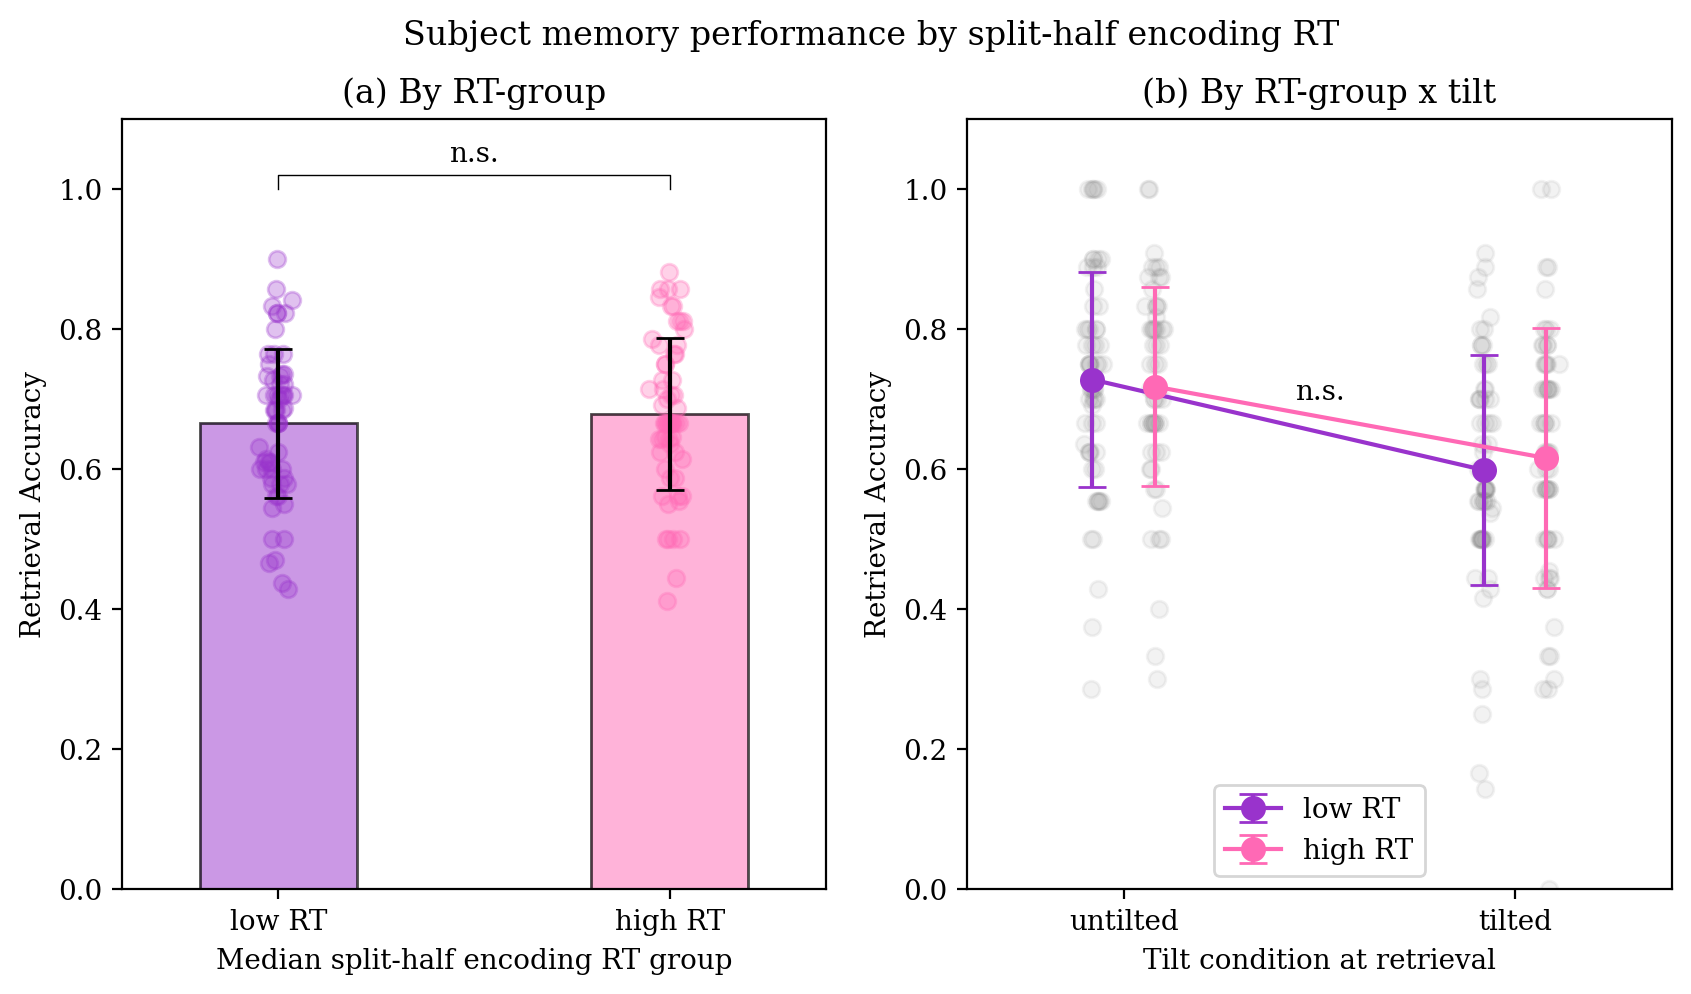

Test for panel A: 
 WilcoxonResult(statistic=785.5, pvalue=0.5878388621773636)
Test for panel B: 
 $\beta = 0.03$, $F(3, 240)$ = $0.65, P = 0.516 $


In [626]:
data = stats_enc_split
slider = False
if slider:
    measure = 'ret_dist'
    ylab = 'Retrieval Slider Error'
    ylims = (0,100)
else:
    measure = 'ret_acc'
    ylab = 'Retrieval Accuracy'
    ylims = (0,1.1)

c = [[.6,.2,.8], [1, .41, .71]] # ['darkorchid', 'hotpink'] 
al = 0.3
al2 = 0.7 # edges

fig, ax = plt.subplots(1,2, figsize = (10,5), dpi = 200)
fig.suptitle('Subject memory performance by split-half encoding RT')
plt.setp(ax, ylim = ylims, xticks = [0,50])

ax[0].set_xlim([-20,70])
ax[0].set_title('(a) By RT-group')
ax[0].set_ylabel(ylab)
ax[0].set_xlabel('Median split-half encoding RT group')
ax[0].set_xticklabels(['low RT','high RT'])
# ax[0].errorbar(x= np.array([0, 50]), 
#             y = data[[measure+'_low', measure+'_high']].mean(), 
#             yerr = data[[measure+'_low', measure+'_high']].std(),
#         capsize =5, marker = 'o', mfc = 'black', mec='black', ms =0, ecolor='black', color='black')
ax[0].bar(np.array([0, 50]), data[[measure+'_low', measure+'_high']].mean(), width=20, color=c, alpha=0.5,
          yerr= data[[measure+'_low', measure+'_high']].std(), capsize=5)
ax[0].bar(np.array([0, 50]), data[[measure+'_low', measure+'_high']].mean(), width=20, color='None', edgecolor='black', alpha=al2)

ax[0].scatter(x = fun.rand_jitter(np.repeat(0, len(data)), 1), y = data[measure+'_low'], color=c[0], alpha=al, label = 'low RT')
ax[0].scatter(x = fun.rand_jitter(np.repeat(50, len(data)), 1), y = data[measure+'_high'], color=c[1], alpha=al, label = 'high RT')
h = 0.02
y = 1
sig = fun.get_sig(sp.wilcoxon(data[measure+'_low'], data[measure+'_high']).pvalue)
ax[0].plot([0, 0, 50, 50], [y, y+h, y+h, y], lw=.5, color = 'black')
ax[0].text(25,y+h*2, sig, ha ='center', fontsize=10)


jit = 0.5
buffer = 4
al = 0.1
ax[1].set_xlim([-20,70])
ax[1].set_title('(b) By RT-group x tilt')
ax[1].set_ylabel(ylab)
ax[1].set_xlabel('Tilt condition at retrieval')
ax[1].set_xticklabels(['untilted','tilted'])
ax[1].errorbar(x= np.array([0, 50])-buffer, 
                y = data[[measure+'_low_0', measure+'_low_50']].mean(), 
                yerr = data[[measure+'_low_0', measure+'_low_50']].std(),
                capsize =5, marker = 'o', mfc = c[0], mec=c[0], ms =8, ecolor=c[0], color=c[0], label = 'low RT')

ax[1].errorbar(x= np.array([0, 50])+buffer, 
                y = data[[measure+'_high_0', measure+'_high_50']].mean(), 
                yerr = data[[measure+'_high_0', measure+'_high_50']].std(),
                capsize =5, marker = 'o', mfc = c[1], mec=c[1], ms =8, ecolor=c[1], color=c[1], label = 'high RT')

ax[1].scatter(x = fun.rand_jitter(np.repeat(0-buffer, len(data)), jit),y = data[measure+'_low_0'], color='gray', alpha=al)
ax[1].scatter(x = fun.rand_jitter(np.repeat(0+buffer, len(data)), jit),y = data[measure+'_high_0'], color='gray', alpha=al)
ax[1].scatter(x = fun.rand_jitter(np.repeat(50-buffer, len(data)), jit),y = data[measure+'_low_50'], color='gray', alpha=al)
ax[1].scatter(x = fun.rand_jitter(np.repeat(50+buffer, len(data)), jit),y = data[measure+'_high_50'], color='gray', alpha=al)
ax[1].text(25,0.7, 'n.s.', ha ='center', fontsize=10)
ax[1].legend(loc = 'lower center')

if save: plt.savefig('/Users/chrisiyer/Downloads/fig4_encoding_split', dpi = 200)
plt.show()

print('Test for panel A: \n', sp.wilcoxon(data[measure+'_low'], data[measure+'_high']))
print('Test for panel B: \n', 
        fun.show_model_parameters(smf.ols("measure ~ tilt * rt_group", data = {
    'measure': np.concatenate([data[measure+'_low_0'], 
                                data[measure+'_high_0'], 
                                data[measure+'_low_50'], 
                                data[measure+'_high_50']]), 
    'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
    'rt_group': np.concatenate([np.repeat(0, len(data)), np.repeat(1, len(data)), 
                                np.repeat(0, len(data)), np.repeat(1, len(data))])
    }), md_bool=False))  

## Statistical Tests

In [32]:
fun.results(stats)


--Encoding--
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=576.5, pvalue=0.5544146611806291)
 - RT by race (Wilcoxon):
WilcoxonResult(statistic=484.0, pvalue=0.0015095002696703438)
 - RT vs. accuracy (OLS):
LinregressResult(slope=1.664689638977179e-06, intercept=0.8129735284549274, rvalue=0.014928712942520846, pvalue=0.9090862635948553, stderr=1.451565050765383e-05, intercept_stderr=0.04783372023518232)

--Retrieval--
 - accuracy by tilt (Wilcoxon):
WilcoxonResult(statistic=305.0, pvalue=7.100485420316709e-06)
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=568.0, pvalue=0.01063344723063325)
 - dist by race (Wilcoxon):
WilcoxonResult(statistic=683.0, pvalue=0.18169475764488696)
 - accuracy by tilt * race (OLS):
$\beta = -0.04$, $F(3, 240)$ = $-1.15, P = 0.253 $

--Encoding-Retrieval--
 - ∆enc_rt vs ∆ret_acc (OLS):
LinregressResult(slope=-2.9219618014427094e-06, intercept=-0.054334637156575626, rvalue=-0.010574857084289964, pvalue=0.9355327367873576, stderr=3.597077